In [1]:
from ctapipe.io import event_source
from ctapipe.calib import CameraCalibrator
from ctapipe.utils import get_dataset
from ctapipe.image import tailcuts_clean
from ctapipe.reco import HillasReconstructor
from ctapipe.image import hillas_parameters
import astropy.units as u
import numpy as np
import copy
from ctapipe.visualization import CameraDisplay
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [3]:
class HillasNotFinite(Exception):
    """
    Error to be raised when hillas parameters are not finite
    """ 
    pass

def reconstruction(event):
    features = {}
    hillas_dict = {}
    pointing_azimuth = {}
    pointing_altitude = {}
    
    for tel_id in event.r0.tels_with_data:
        dl1 = event.dl1.tel[tel_id]
        camera = event.inst.subarray.tels[tel_id].camera
        mask = tailcuts_clean(camera, dl1.image[0], 
                              boundary_thresh=5, 
                              picture_thresh=10, 
                              min_number_picture_neighbors=0)
        telescope_type_name = event.inst.subarray.tels[tel_id].optics.tel_type
        dl1.cleaned = copy.copy(dl1.image[0])
        cleaned = dl1.cleaned
        cleaned[~mask] = 0
        
        if cleaned.sum() > 0:
            try:
                h = hillas_parameters(camera,
                                      cleaned)
                if not all(map(np.isfinite, h.values())):
                    raise HillasNotFinite("bad Hillas parameters")
                    
                hillas_dict[tel_id] = h
                pointing_azimuth[tel_id] = event.mc.tel[tel_id].azimuth_raw * u.rad
                pointing_altitude[tel_id] = ((np.pi/2) - event.mc.tel[tel_id].altitude_raw )* u.rad # this is weird to say the least. 
            except HillasNotFinite:
                pass
        else:
            pass

    if len(hillas_dict) < 2:
        print("mono")
        reconstruction = None
    else:
        reconstruction = hillas_reco.predict(hillas_dict, event.inst, pointing_azimuth, pointing_altitude)
    return reconstruction

In [4]:
pwd = "/home/thomas/Programs/astro/CTAPIPE_DAN/"
filename = 'gamma_20deg_0deg_run100___cta-prod3-lapalma3-2147m-LaPalma_cone10.simtel.gz'
# filename = 'gamma_20deg_0deg_run100___cta-prod3_desert-2150m-Paranal-merged.simtel.gz'
# filename = 'gamma_20deg_0deg_run118___cta-prod3_desert-2150m-Paranal-merged_cone10.simtel.gz'
# filename = 'gamma_20deg_180deg_run11___cta-prod3_desert-2150m-Paranal-merged_cone10.simtel.gz'

# North
layout = np.loadtxt(pwd+'CTA.prod3Nb.3AL4-BN15.lis', usecols=0, dtype=int)
# FlashCam
# layout = np.loadtxt(pwd+'CTA.prod3Sb.3HB9-FG.lis', usecols=0, dtype=int)

# NectarCam
# layout = np.loadtxt(pwd+'CTA.prod3Sb.3HB9-NG.lis', usecols=0, dtype=int)

filename = pwd + filename

# if "Paranal" in filename:
#     layout = [4, 5, 6, 11]
#     print("PARANAL WITH {0}".format(layout))
# elif "palma" in filename:
#     layout = [5, 6, 7, 8]
#     print("LAPALMA WITH {0}".format(layout))
# 
# print("Layout telescopes IDs:".format(layout))
# 
# layout.append(12)
layout = set(layout)

source = event_source(filename)
source.max_events = 50
source.allowed_tels = layout
events = [copy.deepcopy(event) for event in source]

In [5]:
#!more /home/thomas/Programs/astro/CTAPIPE_DAN/CTA.prod3Sb.3HB9-FG.lis

In [6]:
# Calibration
cal = CameraCalibrator(None, None, r1_product='HESSIOR1Calibrator', extractor_product='NeighbourPeakIntegrator')
for event in events:
    cal.calibrate(event)
    
# Find "big" event
events_amplitude = []
for event in events:
    event_amplitude = 0
    for tel_id in event.r0.tels_with_data:
        if event.dl1.tel[tel_id].image is not None:
            event_amplitude += event.dl1.tel[tel_id].image[0].sum()
    events_amplitude.append(event_amplitude)
events_amplitude = np.array(events_amplitude)

mm = events_amplitude.argmax()

print(mm)
event = events[mm]

# Hillas reconstruction
hillas_reco = HillasReconstructor()
reco = reconstruction(event)
print(event.r0.tels_with_data)
for tel_id in event.r0.tels_with_data:
    print(event.inst.subarray.tel[tel_id].camera.cam_id)

4
{67, 5, 6, 7, 8, 72, 117, 60, 61, 62, 63}
NectarCam
LSTCam
LSTCam
LSTCam
LSTCam
NectarCam
NectarCam
NectarCam
NectarCam
NectarCam
NectarCam


In [7]:
# event.r0.tels_with_data
# 
# print(event.mc.tel[37].azimuth_raw)
# print(event.mc.tel[37].altitude_raw*180/np.pi)
# event.mc.tel[37]
# 
# event.inst.subarray.optics_types
# 
# info = {'CHEC': [],
#         'ASTRICam': [],
#         'LSTCam': [],
#         'FlashCam': [],
#         'DigiCam': [],
#         'NectarCam': [],
#         'SCTCam': [],
#        }
# 
# 
# list(info.keys())
# info
# from astropy.io import ascii
# ascii.write(info, names=list(info.keys()), output="file.dat")
# event = events[4]
# for tel_id in event.r0.tels_with_data:
#     telescope = event.inst.subarray.tel[tel_id]
#     #info[telescope.camera.cam_id] = [telescope.camera.pix_x, telescope.camera.pix_y ]
#     print("{0};   \t{1}    \t  {2} ".format(telescope.optics.identifier[0], telescope.camera.cam_id, telescope.camera.pix_x.shape))
#     

28
113
123
192
180
62
50
62
112
92
35


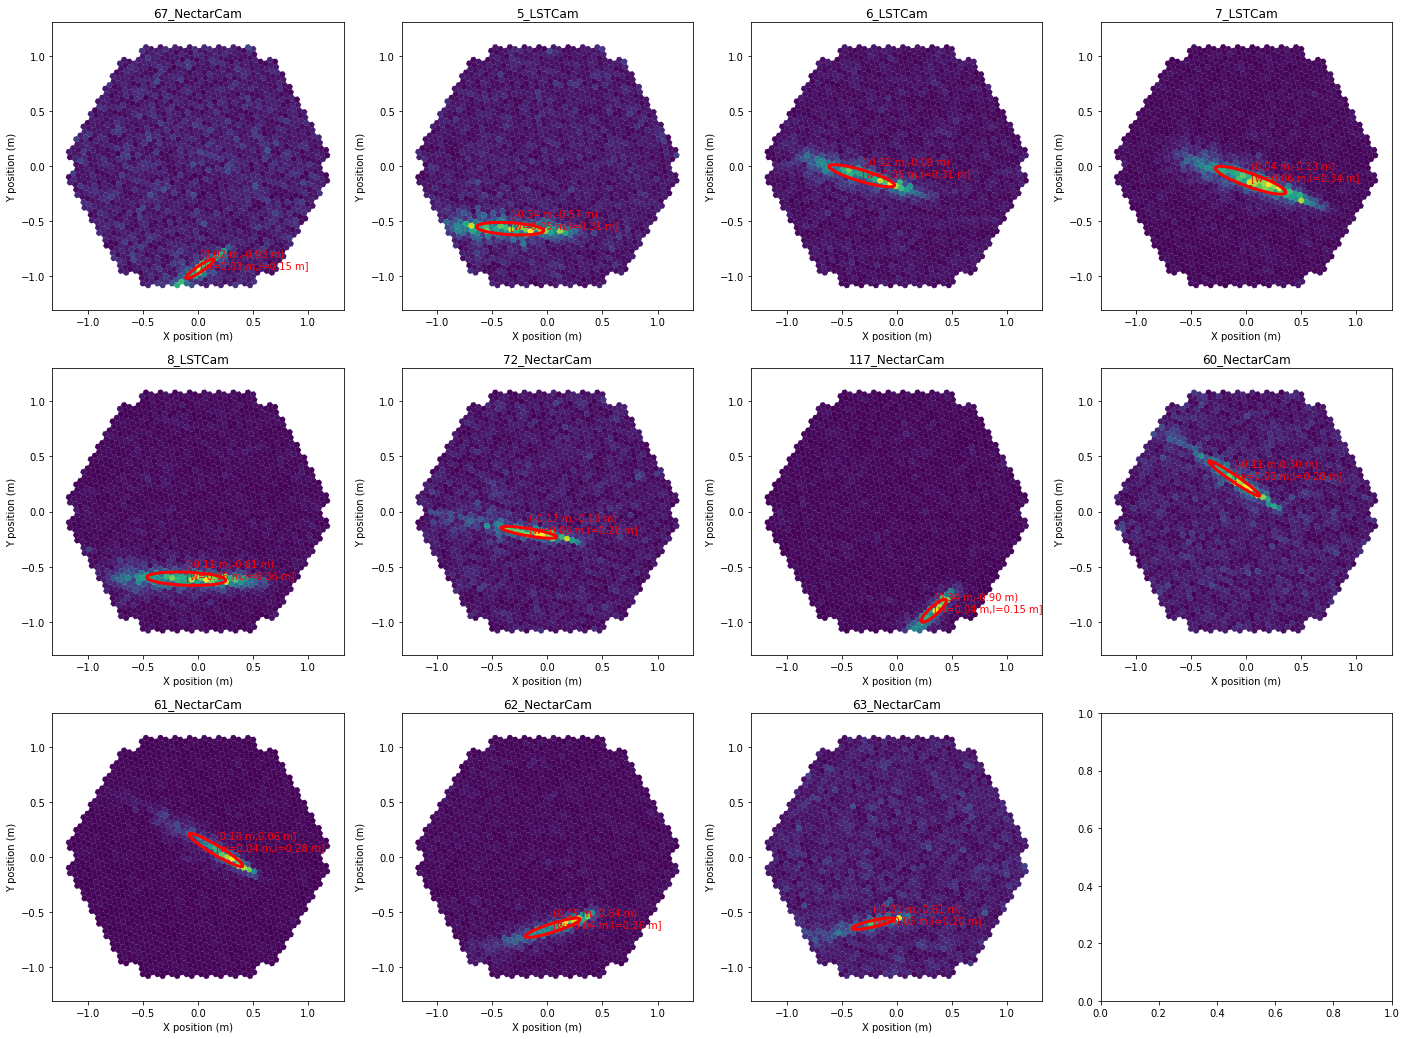

In [8]:
ncol = 4
nrow = len(event.r0.tels_with_data)//ncol + 1 * (len(event.r0.tels_with_data)%ncol > 0)
fs = 6

fig, axes = plt.subplots(nrow, ncol, figsize=(fs*ncol, fs*nrow))

hillas_dict = {}
cleaned_dict = {}

for ii, tel_id in enumerate(event.r0.tels_with_data):
    camera = event.inst.subarray.tel[tel_id].camera
    image = event.dl1.tel[tel_id].image[0]
    r0 = event.r0.tel[tel_id].image[0]
    cleaned = event.dl1.tel[tel_id].cleaned
    print(len(np.nonzero(cleaned)[0]))
    disp = CameraDisplay(camera, image, ax = axes.ravel()[ii])
    disp.axes.set_title("{0}_{1}".format(str(tel_id), disp.geom.cam_id))

    cleaned_dict[tel_id] = cleaned
        
    if cleaned.sum() > 0:
        hillas = hillas_parameters(camera, cleaned)
        hillas_dict[tel_id] = hillas
        #disp = CameraDisplay(camera, cleaned, ax=axes.ravel()[ii])
        disp.overlay_moments(hillas, color='RED', linewidth=3, zorder=10)
plt.show()

In [9]:
%load_ext autoreload
%autoreload 2
from CREED_VTK import CREED_VTK

In [14]:
render = CREED_VTK(event)
# render.event_type(clean_level = "clean", clean_dict=cleaned_dict)
# render.add_arrows_camera_frame()
render.add_gnd_tels()
render.add_gnd_frame(size=300)
render.add_tilted_frame(size=300)
render.add_tilted_tels()

render.camera_view(elev=20)
render.tel_labels()
render.show(width= 1000, height=800)

[67, 5, 6, 7, 8, 72, 117, 60, 61, 62, 63]
{'alt': 69.99999967119774, 'az': 0.0}
{'alt': 69.99999967119774, 'az': 0.0}
{'alt': 69.99999967119774, 'az': 0.0}
{'alt': 69.99999967119774, 'az': 0.0}
{'alt': 69.99999967119774, 'az': 0.0}
{'alt': 69.99999967119774, 'az': 0.0}
{'alt': 69.99999967119774, 'az': 0.0}
{'alt': 69.99999967119774, 'az': 0.0}
{'alt': 69.99999967119774, 'az': 0.0}
{'alt': 69.99999967119774, 'az': 0.0}
{'alt': 69.99999967119774, 'az': 0.0}
69d59m59.9988s
